In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import polars as pl
import toml
from support import preprocess
from support import apply_median_filter
from scipy.signal import find_peaks

In [2]:
_base_pth = toml.load("data_path.toml")['files']['pth']
_folder_name = 'normal_ss_t1'
# _folder_name = '14'

_data_pth = os.path.join(_base_pth, _folder_name)

_mobbo_base_names = [
    'mobbo1.csv',
    'mobbo2.csv',
    'mobbo3.csv',
    'mobbo4.csv',
    'mobbo5.csv',
    'mobbo6.csv',
                     ]

In [3]:
dfs = {'m1':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[0])),
       'm2':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[1])),
       'm3':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[2])),
       'm4':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[3])),
       'm5':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[4])),
       'm6':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[5]))}

## Changing polarity for two boards m5 and m6

In [4]:
dfs['m5'] = dfs['m5'].with_columns([(pl.col('f1')*-1).alias('f1'),
                                    (pl.col('f2')*-1).alias('f2'),
                                    (pl.col('f3')*-1).alias('f3'),
                                    (pl.col('f4')*-1).alias('f4'),])

dfs['m6'] = dfs['m6'].with_columns([(pl.col('f1')*-1).alias('f1'),
                                    (pl.col('f2')*-1).alias('f2'),
                                    (pl.col('f3')*-1).alias('f3'),
                                    (pl.col('f4')*-1).alias('f4'),])

## Pre processing files

In [5]:
dfs = preprocess(dfs)
dfs = apply_median_filter(dfs)

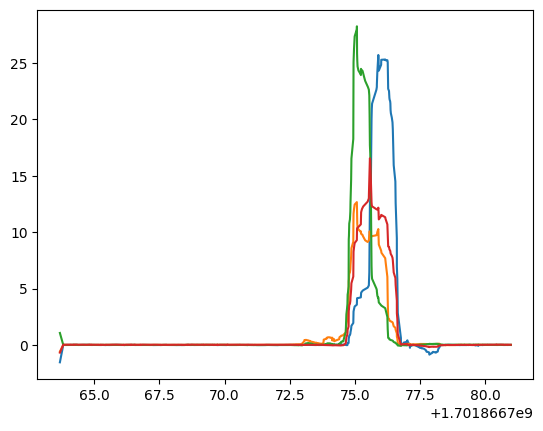

In [6]:
plt.plot(dfs['m5']['timestamp'], dfs['m5']['f1'], label='f1')
plt.plot(dfs['m5']['timestamp'], dfs['m5']['f2'], label='f2')
plt.plot(dfs['m5']['timestamp'], dfs['m5']['f3'], label='f3')
plt.plot(dfs['m5']['timestamp'], dfs['m5']['f4'], label='f4')

## Calculating local COP

In [7]:
for _df_name in dfs.keys():
    _temp_df = dfs[_df_name]
    cop_x = []
    cop_y = []
    _weight_list = []
    for i in range(len(dfs[_df_name]['timestamp'])):
        
        _weight = _temp_df['f1'][i] + _temp_df['f2'][i] + _temp_df['f3'][i] + _temp_df['f4'][i]
        if _weight>2:
            cop_x.append((((_temp_df['f3'][i]+_temp_df['f4'][i])-(_temp_df['f1'][i]+_temp_df['f2'][i]))*22.5/_weight))
            cop_y.append((((_temp_df['f1'][i]+_temp_df['f4'][i])-(_temp_df['f2'][i]+_temp_df['f3'][i]))*30/_weight))
        else:
            cop_x.append(np.nan)
            cop_y.append(np.nan)
        _weight_list.append(_weight)
    cop_x = pl.Series('cop_x',cop_x)
    cop_y = pl.Series('cop_y',cop_y)
    _weight_list = pl.Series('w', _weight_list)
    _temp_df.insert_column(-1, cop_x)
    _temp_df.insert_column(-1, cop_y)
    _temp_df.insert_column(-1, _weight_list)
    dfs[_df_name] = _temp_df

## Local COP plot for all boards

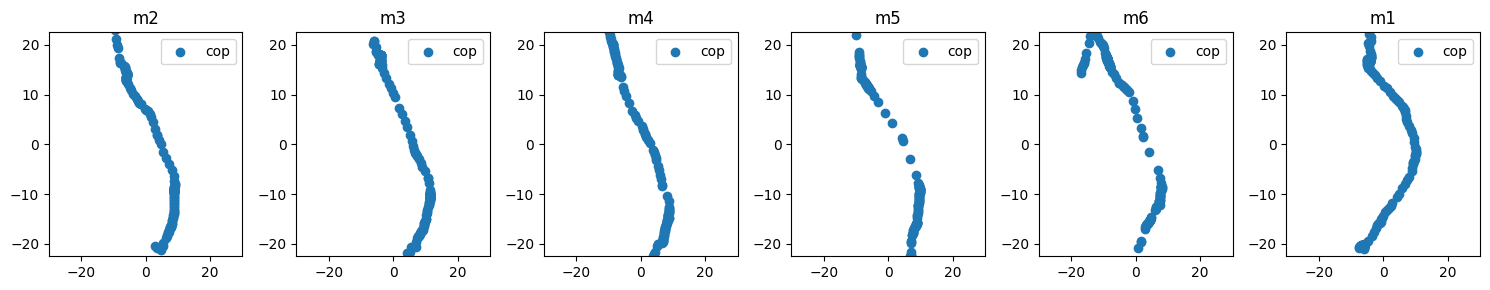

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 3))
fig.subplots_adjust(hspace=0)
# Plotting the data on each subplot
for i, df_name in enumerate(dfs.keys()):
    axes[i].scatter(dfs[df_name]['cop_x'], dfs[df_name]['cop_y'], label='cop')
    axes[i].set_title(df_name)
    axes[i].set_xlim(-30, 30)
    axes[i].set_ylim(-22.5, 22.5)
    axes[i].legend()
plt.tight_layout()
plt.show()


## Calculating global COP

In [9]:
global_x = []
global_y = []
_length = 45
_breadth = 60

_w = np.array([
    dfs['m1']['w'],
    dfs['m2']['w'],
    dfs['m3']['w'],
    dfs['m4']['w'],
    dfs['m5']['w'],
    dfs['m6']['w'],
]).T

_ws = np.nansum(_w, axis=1)

for i in range(len(dfs['m1'])):
    
    x = np.nansum([_w[i][0]*(dfs['m1']['cop_x'][i] + _length/2),
                _w[i][1]*(dfs['m2']['cop_x'][i] + _length/2),
                _w[i][2]*(dfs['m3']['cop_x'][i] + _length/2),
                _w[i][3]*(dfs['m4']['cop_x'][i] + _length/2),
                _w[i][4]*(dfs['m5']['cop_x'][i] + _length/2),
                _w[i][5]*(dfs['m6']['cop_x'][i] + _length/2)])/_ws[i]

    y = np.nansum([_w[i][0]*(dfs['m1']['cop_y'][i] +    _breadth/2),
                _w[i][1]*(dfs['m2']['cop_y'][i] + 3* _breadth/2),
                _w[i][2]*(dfs['m3']['cop_y'][i] + 5* _breadth/2),
                _w[i][3]*(dfs['m4']['cop_y'][i] + 7* _breadth/2),
                _w[i][4]*(dfs['m5']['cop_y'][i] + 9* _breadth/2),
                _w[i][5]*(dfs['m6']['cop_y'][i] + 11*_breadth/2)])/_ws[i]
    if x == 0:
        x = np.nan
    if y == 0:
        y = np.nan
    
    global_x.append(x)
    global_y.append(y)
global_cop = pd.DataFrame({'gx':global_x, 'gy': global_y})

Text(0.5, 1.0, 'Global COP')

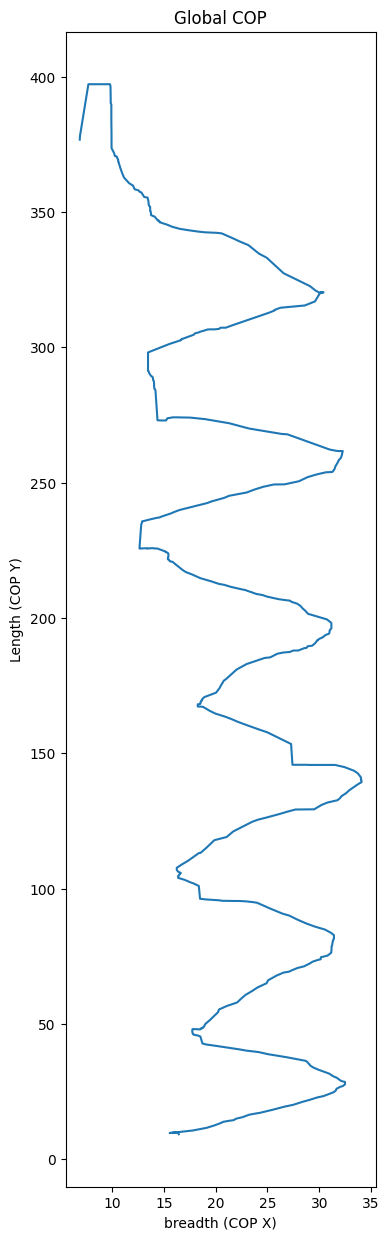

In [10]:
plt.figure(figsize=(4,15))
plt.plot(global_cop.gx.rolling(9).median(), global_cop.gy.rolling(9).median())
plt.ylabel('Length (COP Y)')
plt.xlabel('breadth (COP X)')
plt.title('Global COP')

## Finding peaks

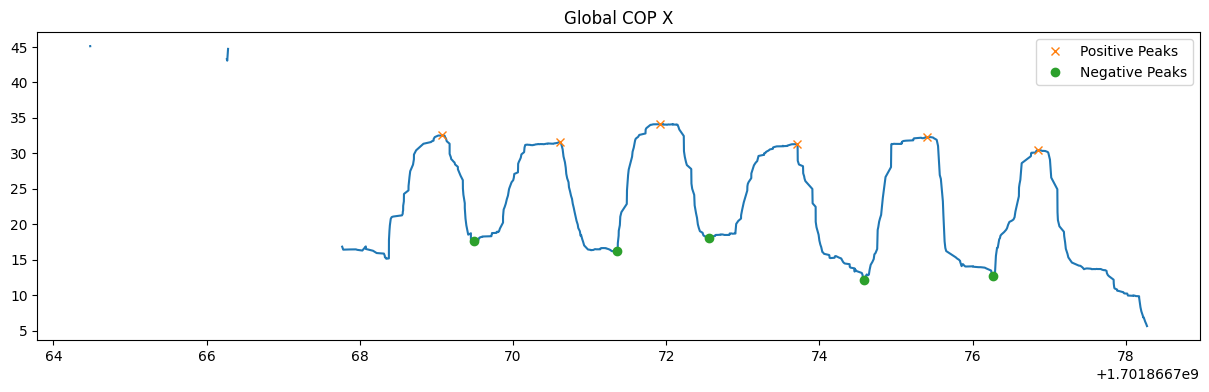

In [11]:
global_x = np.array(global_x)
plt.figure(figsize=(15,4))
plt.plot(dfs['m1']['timestamp'], global_x)
positive_peaks, _ = find_peaks(global_x, width=12, height=20)
plt.plot(dfs['m1']['timestamp'][positive_peaks], global_x[positive_peaks], 'x', label='Positive Peaks')

negative_peaks, _ = find_peaks(-global_x, width=12)
plt.plot(dfs['m1']['timestamp'][negative_peaks], global_x[negative_peaks], 'o', label='Negative Peaks')
plt.title('Global COP X')
plt.legend()

In [12]:
# positive = right foot
# negative = left foot

minimum_cycles = np.min([len(positive_peaks), len(negative_peaks)])

rf = positive_peaks[:minimum_cycles]
lf = negative_peaks[:minimum_cycles]

rf_pos = []
lf_pos = []

rf_time = []
lf_time = []

for i in range(minimum_cycles):
    rf_pos.append([global_x[rf[i]], global_y[rf[i]]])
    lf_pos.append([global_x[lf[i]], global_y[lf[i]]])
    rf_time.append(dfs['m1']['timestamp'][int(rf[i])])
    lf_time.append(dfs['m1']['timestamp'][int(lf[i])])
    
rf_pos = np.array(rf_pos)
lf_pos = np.array(lf_pos)
rf_time = np.array(rf_time)
lf_time = np.array(lf_time)

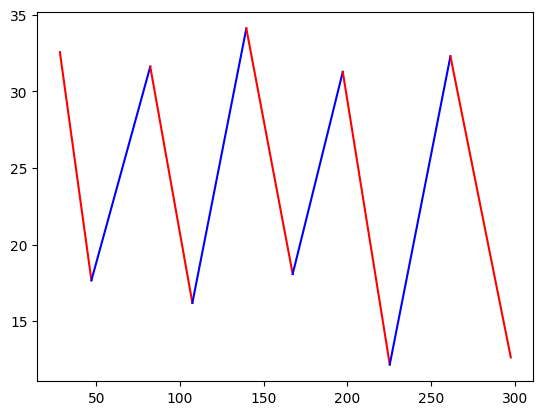

In [13]:
for i in range(minimum_cycles*2 - 1):
    if i%2 == 0:
        plt.plot([rf_pos[i//2][1], lf_pos[i//2][1]], [rf_pos[i//2][0], lf_pos[i//2][0]], 'r')
    else:
        plt.plot([lf_pos[i//2][1], rf_pos[i//2+1][1]], [lf_pos[i//2][0], rf_pos[i//2+1][0]], 'b')

In [14]:
right_steps = []
left_steps = []

for i in range(minimum_cycles*2 - 1):
    if i%2 == 0:
        right_steps.append(np.linalg.norm(rf_pos[i//2] - lf_pos[i//2], axis=0))
    else:
        left_steps.append(np.linalg.norm(lf_pos[i//2] - rf_pos[i//2+1], axis=0))
        
min_steps = min(len(right_steps), len(left_steps))
steps_df = pd.DataFrame({'right_swing':right_steps[:min_steps], 'left_swing':left_steps[:min_steps]})

In [15]:
right_steps = []
left_steps = []

for i in range(minimum_cycles*2 - 1):
    if i%2 == 0:
        right_steps.append(-(rf_pos[i//2][1] - lf_pos[i//2][1]))
    else:
        left_steps.append((lf_pos[i//2][1] - rf_pos[i//2+1][1]))
        
min_steps = min(len(right_steps), len(left_steps))
steps_df = pd.DataFrame({'Steps':right_steps[:min_steps]})

## Step parameters

Text(970.81045751634, 0.5, 'Step time (s)')

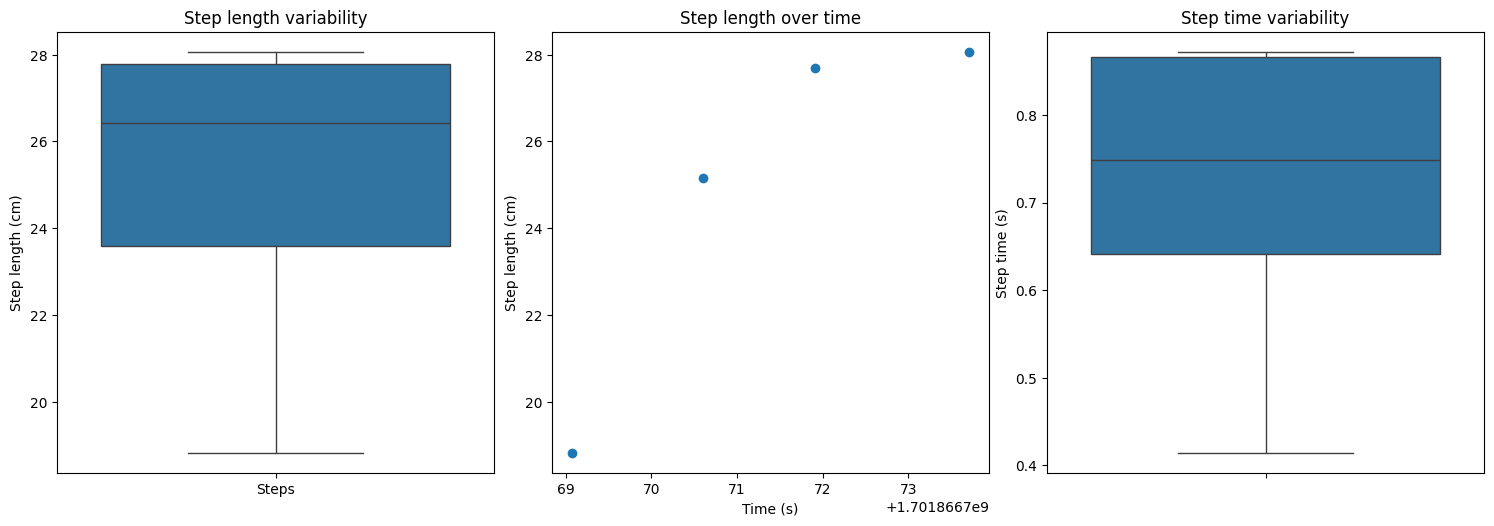

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.tight_layout()
sns.boxplot(data=steps_df, ax=axes[0])
axes[0].set_ylabel('Step length (cm)')
axes[0].set_title('Step length variability')
axes[1].scatter(rf_time[:len(steps_df['Steps'])],steps_df['Steps'])
axes[1].set_title('Step length over time')
axes[1].set_ylabel('Step length (cm)')
axes[1].set_xlabel('Time (s)')
sns.boxplot(data=abs(rf_time - lf_time), ax=axes[2])
axes[2].set_title('Step time variability')
axes[2].set_ylabel('Step time (s)')


## Stride parameters

In [17]:
right_stride_length = []

for i in range(minimum_cycles-1):
    if i != minimum_cycles:
        right_stride_length.append(rf_pos[i][1] - rf_pos[i+1][1])

right_stride_time = np.diff(rf_time)
stride_df = pd.DataFrame({'Stride':right_stride_length[:min_steps]})
stride_time = pd.DataFrame({'stride_time': right_stride_time})

Text(510.4494949494949, 0.5, 'Time (s)')

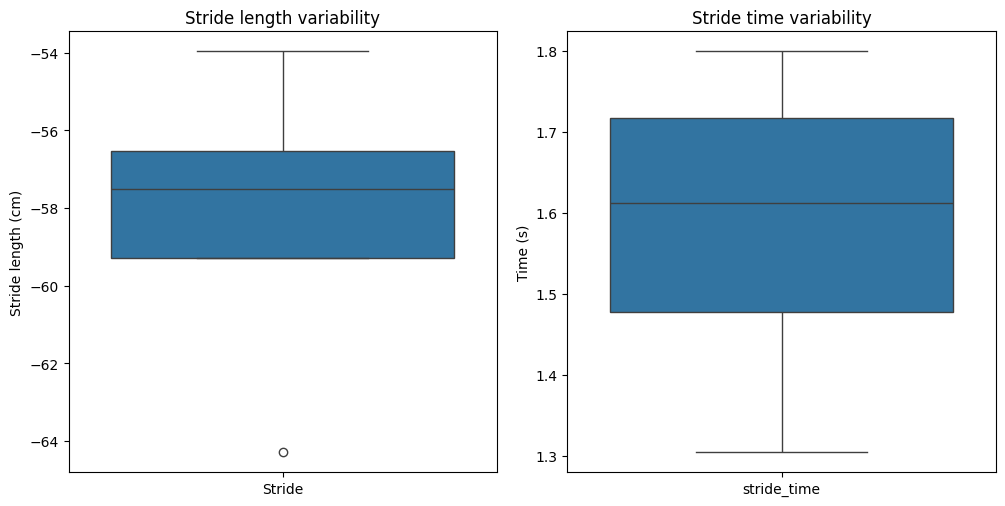

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.tight_layout(w_pad=2)
sns.boxplot(data=stride_df, ax=axes[0])
axes[0].set_ylabel('Stride length (cm)')
axes[0].set_title('Stride length variability')
sns.boxplot(data=stride_time, ax=axes[1])
axes[1].set_title('Stride time variability')
axes[1].set_ylabel('Time (s)')


## Step width

In [19]:
stride_width = []

for i in range(minimum_cycles):
    stride_width.append(rf_pos[i][0] - lf_pos[i][0])

width_df = pd.DataFrame({'width':stride_width[:min_steps]})

Text(0.5, 1.0, 'Step width')

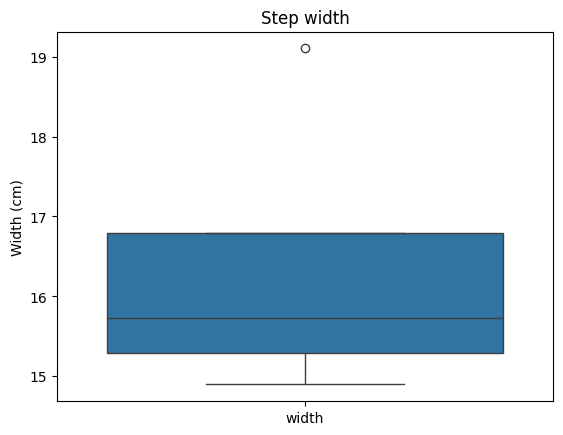

In [20]:
sns.boxplot(data=width_df)
plt.ylabel('Width (cm)')
plt.title('Step width')

In [58]:
steps_df

,Steps
0,18.831976
1,25.170456
2,27.699363
3,28.061675


In [83]:
abs(rf_time - lf_time)

array([0.41454458, 0.74816275, 0.64170814, 0.86655116, 0.87176323])

In [85]:
plt_df = width_df
plt_df['steps'] = steps_df['Steps'][:len(width_df)]

plt_df2 = pd.DataFrame({'step_time': abs(rf_time - lf_time)[:len(right_stride_time)],'stride_time': right_stride_time})

In [108]:
stride_df

,Stride
0,-53.970119
1,-57.392175
2,-57.620628
3,-64.290379


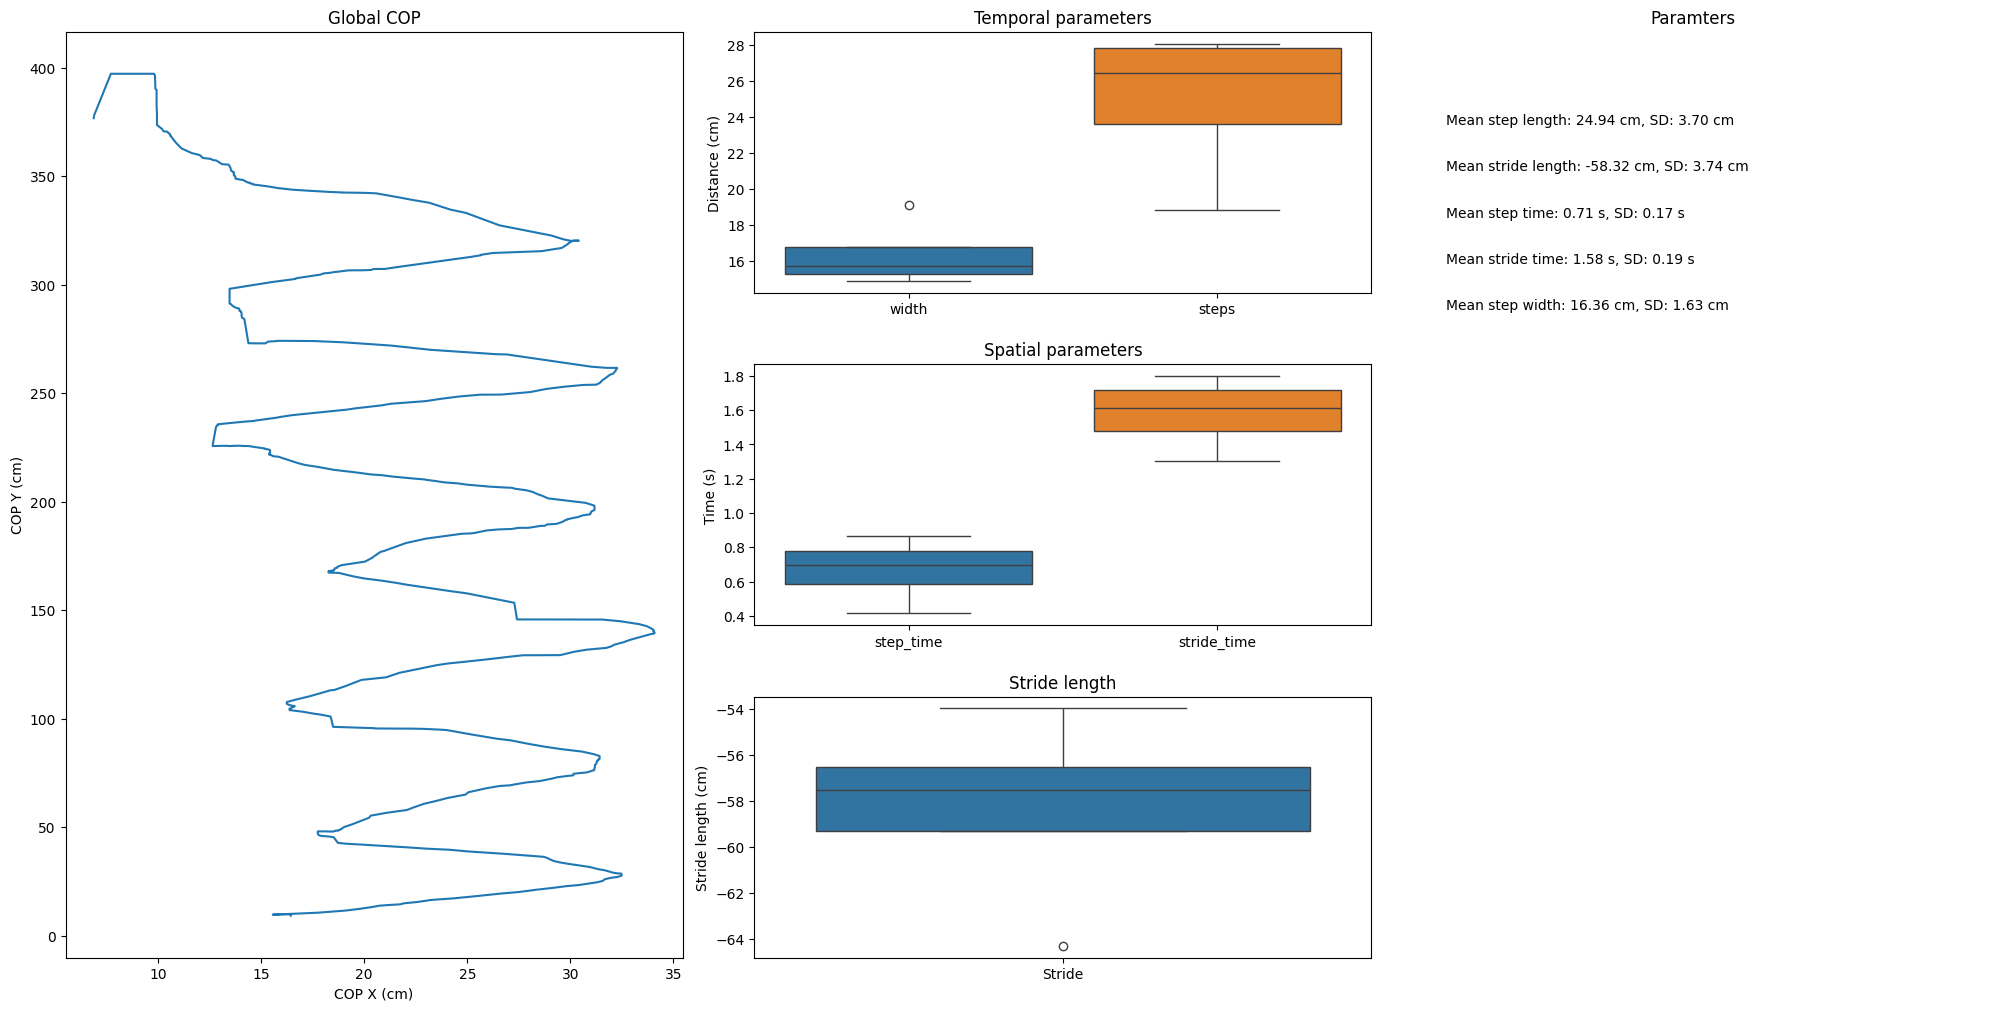

In [113]:
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

fig = plt.figure(layout="constrained", figsize=(15, 10))

gs = GridSpec(3, 3, figure=fig)
cop_ax = fig.add_subplot(gs[0:, 0])
tem_ax = fig.add_subplot(gs[0, 1])
spa_ax = fig.add_subplot(gs[1, 1])
stride_ax = fig.add_subplot(gs[2, 1])

text_ax = fig.add_subplot(gs[0:, 2])
text_ax.axis('off')
# ax5 = fig.add_subplot(gs[1, 2])

cop_ax.plot(global_cop.gx.rolling(9).median(), global_cop.gy.rolling(9).median())
cop_ax.set_ylabel('COP Y (cm)')
cop_ax.set_xlabel('COP X (cm)')
cop_ax.set_title('Global COP')

tem_ax.set_title('Temporal parameters')
sns.boxplot(data=plt_df, ax=tem_ax)
tem_ax.set_ylabel('Distance (cm)')

spa_ax.set_title('Spatial parameters')
sns.boxplot(data=plt_df2, ax=spa_ax)
spa_ax.set_ylabel('Time (s)')

stride_ax.set_title('Stride length')
sns.boxplot(data=stride_df, ax=stride_ax)
stride_ax.set_ylabel('Stride length (cm)')

text_ax.set_title('Paramters')
text_ax.text(0.1, 0.9, f"Mean step length: {np.mean(steps_df['Steps']):.2f} cm, SD: {np.std(steps_df['Steps']):.2f} cm")
text_ax.text(0.1, 0.85, f"Mean stride length: {np.mean(stride_df['Stride']):.2f} cm, SD: {np.std(stride_df['Stride']):.2f} cm")
text_ax.text(0.1, 0.8, f"Mean step time: {np.mean(abs(rf_time - lf_time)):.2f} s, SD: {np.std(abs(rf_time - lf_time)):.2f} s")
text_ax.text(0.1, 0.75, f"Mean stride time: {np.mean(right_stride_time):.2f} s, SD: {np.std(right_stride_time):.2f} s")
text_ax.text(0.1, 0.7, f"Mean step width: {np.mean(width_df['width']):.2f} cm, SD: {np.std(width_df['width']):.2f} cm")


plt.show()

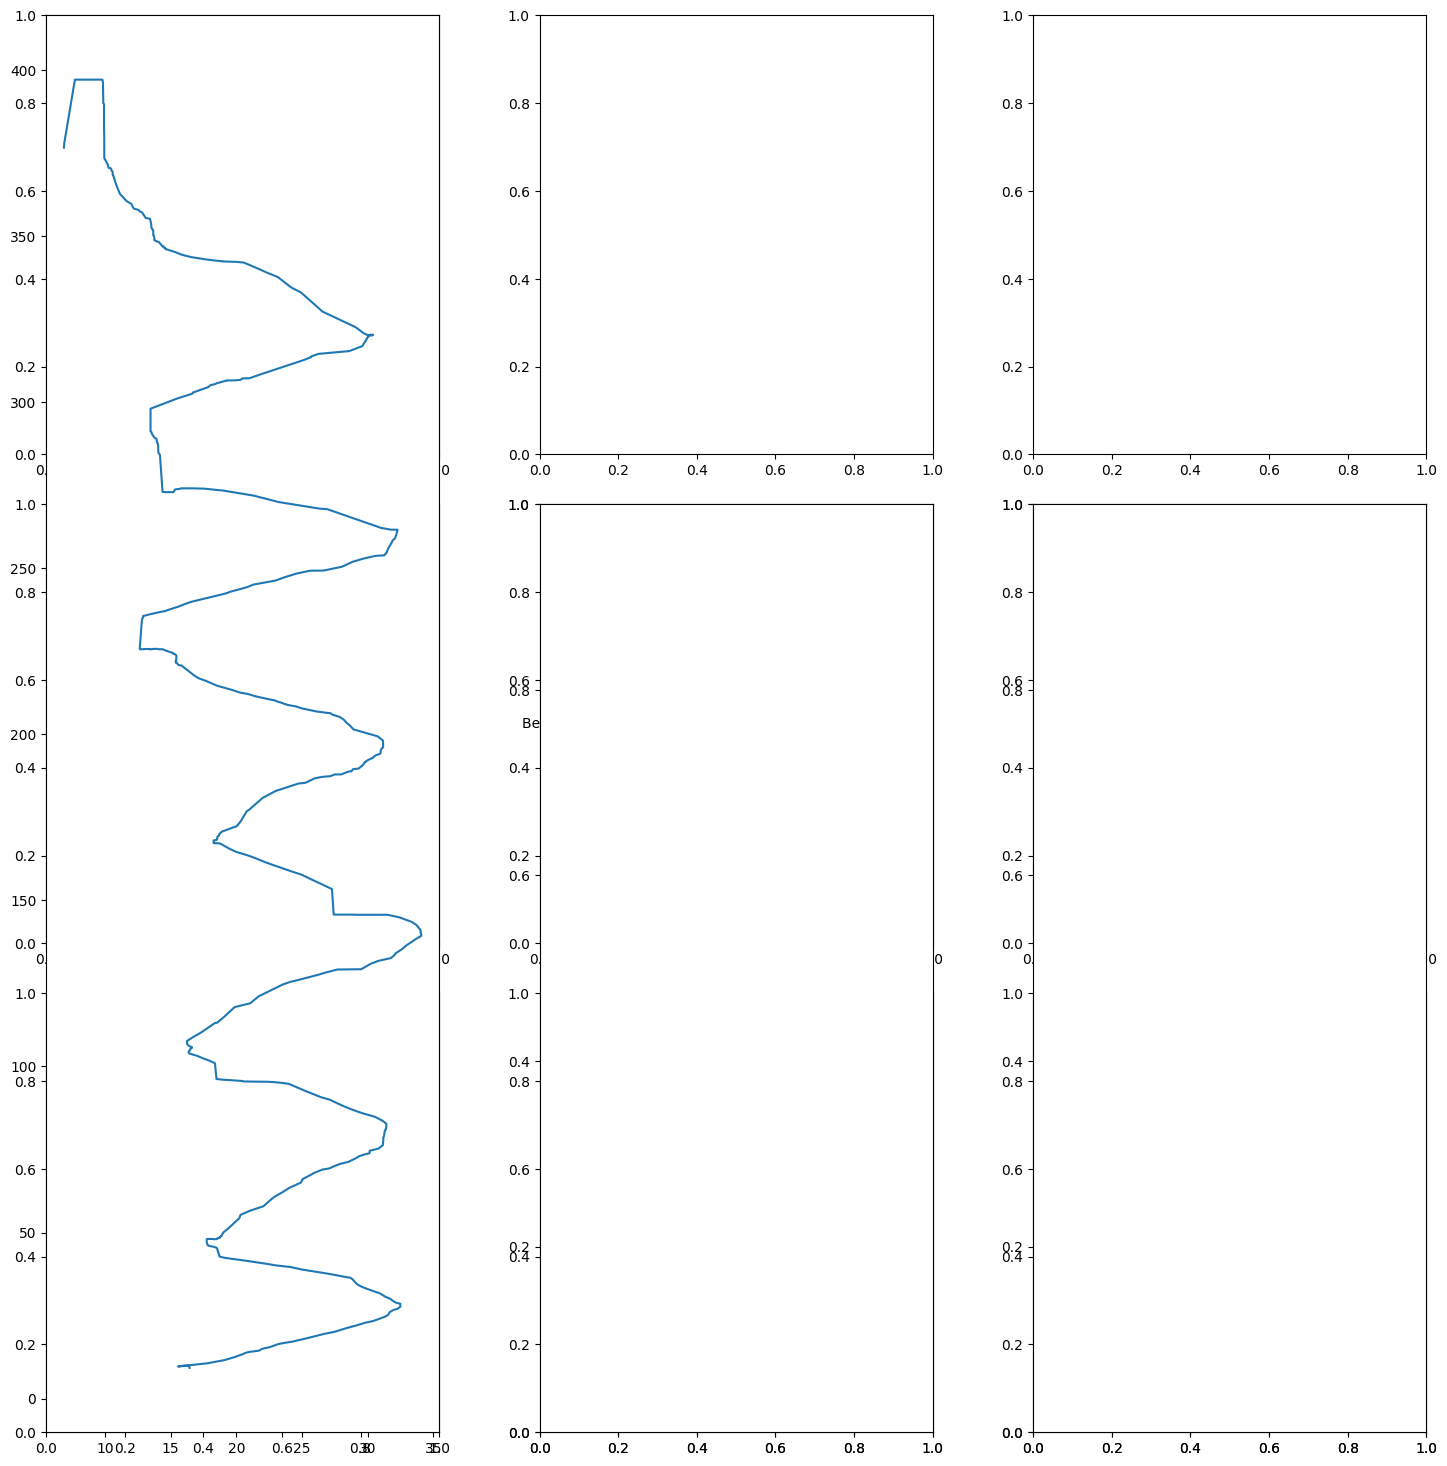

In [43]:

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
gs = axs[0, 0].get_gridspec()


axbig = fig.add_subplot(gs[0:, 0])
axbig.plot(global_cop.gx.rolling(9).median(), global_cop.gy.rolling(9).median())

middle = fig.add_subplot(gs[1:, 1])

right = fig.add_subplot(gs[1:, 2])

# Show texts
axs[1,1].text(0.1, 0.5, 'Begin text', horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes)
axs[1,1].text(0.1, 0.5, 'Begin texta asdf', horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes)

fig.tight_layout()

plt.show()